# 240. CIFAR-10 을 이용한 CNN 구축

- **CNN**을 학습하여 CIFAR-10 데이터베이스의 이미지를 분류합니다.

<img src='https://production-media.paperswithcode.com/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg' width=600 />


- mean, std ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 로 normalize 된 image 의 unnormalization 방법
    - image = image * 0.5 + 0.5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
BATCH_SIZE = 64
lr = 0.01

## Data Download 및 Data Loader 를 이용하여 Train, Validation data 준비

transforms.Compose는 주어진 순서대로 여러 변환을 적용하는 함수입니다. 코드에서 다음과 같이 네 가지 변환을 연속적으로 적용하도록 설정하였습니다:
- transforms.RandomHorizontalFlip(): 이미지를 수평으로 무작위로 뒤집는 변환입니다. 이는 데이터 증강(augmentation)을 통해 모델이 수평 뒤집힘에 대해 불변성(invariance)을 가지도록 도와줍니다.  
- transforms.RandomRotation(10): 이미지를 -10에서 10 사이의 무작위 각도로 회전시킵니다. 이 또한 데이터 증강의 일부로, 모델이 회전에 대해 불변성을 가지도록 돕습니다.  
- transforms.ToTensor(): 이미지나 numpy.ndarray (H x W x C)를 torch.FloatTensor로 변환합니다 (C x H x W). 이 변환에서는 픽셀의 강도(intensity)가 [0., 1.] 범위로 조정됩니다.  
- transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)): 각 채널의 색상을 정규화합니다. 이 변환은 입력 데이터를 특정 평균(mean)과 표준편차(std)를 사용하여 정규화합니다. 여기서는 모든 채널에 대해 평균과 표준편차가 0.5로 설정되어 있습니다.

In [4]:
# image augmentation
composed = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))   # (mean, std)
                                    ])

train_data = datasets.CIFAR10(root='./data', 
                train=True, download=True, transform=composed)                
test_data  = datasets.CIFAR10(root='./data', 
                train=False, download=True, transform=composed)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 170498071/170498071 [00:01<00:00, 105685221.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
print(train_data)
print()
print(test_data)
print()
print(train_data[0][0].shape)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

torch.Size([3, 32, 32])


In [6]:
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### 일부 Data 시각화

- np.transpose(x, (1, 2, 0)) 부분은 PyTorch와 일반 이미지 표현 간의 축 차이를 보정합니다. PyTorch는 이미지를 (채널, 높이, 너비) 형식으로 표현하는 반면, 일반적으로 사용하는 이미지 표현 형식은 (높이, 너비, 채널)입니다. np.transpose를 사용하여 이 축 차이를 해결합니다.

* 0.5 + 0.5 부분은 이전에 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))를 사용하여 정규화한 것을 되돌리는 과정입니다. 정규화 단계에서 각 채널의 색상이 평균을 빼고 표준편차로 나누어졌으므로, 정규화를 취소하려면 반대로 각 채널의 색상에 표준편차를 곱하고 평균을 더하면 됩니다.

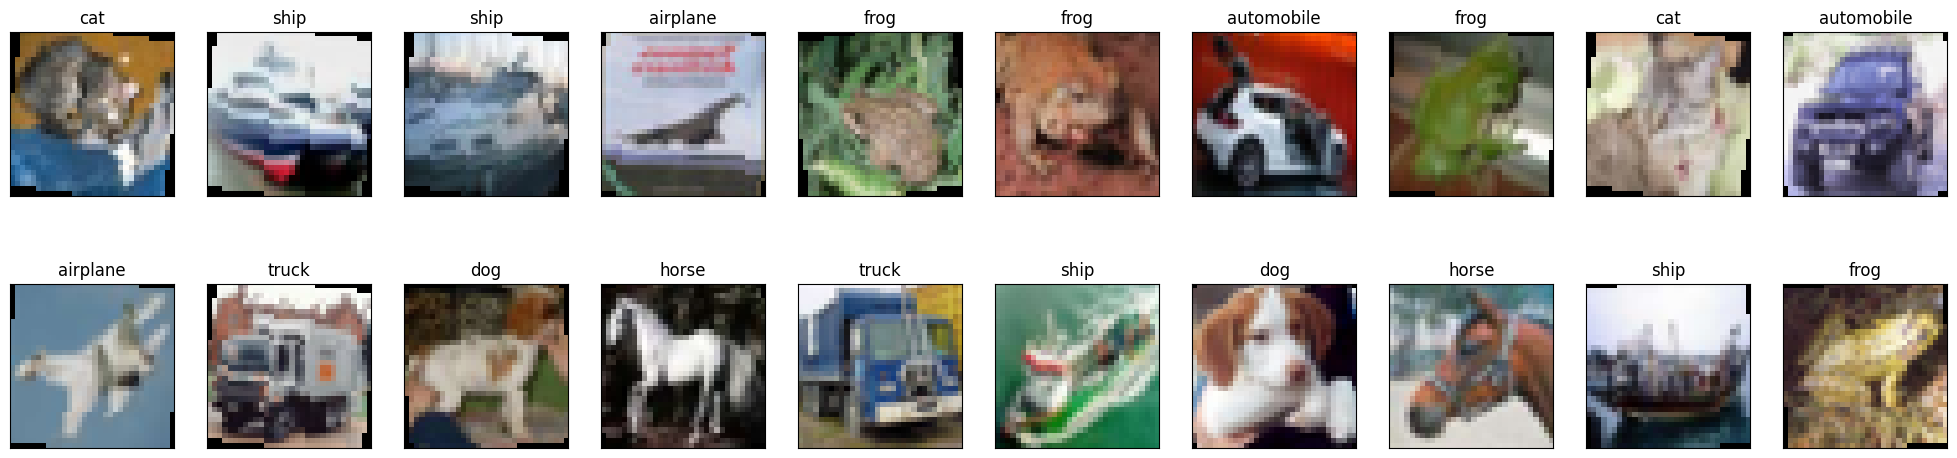

In [7]:
plt.figure(figsize=(25, 6))
for i, (x, y) in enumerate(test_data):
    if i > 19:
        break
    plt.subplot(2, 10, i+1)
    img = np.transpose(x, (1, 2, 0)) * 0.5 + 0.5    # unnormalize
    plt.imshow(img)  
    plt.title(cifar10_classes[y])
    plt.xticks([])
    plt.yticks([])

plt.show()

## Model build

### Custom Model

- Output Size = (W - F + 2P) / S + 1  
- output_size / Maxpool(2) 

이 공식은 CNN(Convolutional Neural Network)의 각 계층의 출력 크기를 계산하는 데 사용됩니다.

- W: 입력의 크기, F: 필터(또는 커널)의 크기, P: 패딩의 크기, S: 스트라이드의 크기, poolsize: 풀링 계층의 필터 크기  

출력 크기는 다음 계층의 입력 크기가 됩니다. 

In [8]:
def output_size(W, F, P, S, poolsize=1):
    size = (W - F + 2*P)/S + 1
    return size if poolsize == 1 else size / poolsize

input image size : (32, 32), kernel size : 3, padding : 1, stride : 1 인 경우 3번 convolution을 하면 최종 image size는 다음과 같이 계산

In [9]:
out1 = output_size(32, 3, 1, 1, poolsize=2)
print(out1)
out2 = output_size(out1, 3, 1, 1, poolsize=2)
print(out2)
out3 = output_size(out2, 3, 1, 1, poolsize=2)
out3

16.0
8.0


4.0

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  #pool size = 2

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Dropout(0.25),
        )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4 * 4 * 64 , 256),  # image size * channels
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_relu_stack(x)
        #print(x.shape)
        # return
        logits = self.linear_relu_stack(x)
        return logits

### Model 생성

In [11]:
model = Net()
model.to(device)

Net(
  (conv_relu_stack): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Dropout(p=0.25, inplace=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1024, out_features

In [12]:
print("model parameters :", sum(p.numel() for p in model.parameters()))

model parameters : 289290


In [13]:
x = next(iter(train_loader))[0:1][0]
x.shape

torch.Size([64, 3, 32, 32])

In [14]:
pred = model(x.to(device))
pred.shape

torch.Size([64, 10])

### Loss Function

In [15]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [16]:
import time
s = time.time()

LOSS, VAL_LOSS, ACC, VAL_ACC = [], [], [], []

EPOCHS = 30

for epoch in range(EPOCHS):
    
    model.train()  # train mode
    
    train_loss = 0
    train_acc = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        z = model(x)
        loss = criterion(z, y)
        train_loss += loss.item()
        _, y_pred = torch.max(z, 1)
        train_acc += (y_pred == y).sum().item() / len(y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss/len(train_loader)
    train_acc = train_acc / len(train_loader) 
    LOSS.append(train_loss)
    ACC.append(train_acc)
    
    model.eval()   # evaluation mode
        
    val_loss = 0
    val_acc = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        
        z = model(x)
        loss = criterion(z, y)

        val_loss += loss.item()
        _, y_pred = torch.max(z, 1)
        val_acc += (y_pred == y).sum().item() /len(y) 
        
    val_loss = val_loss / len(test_loader)
    val_acc = val_acc / len(test_loader)
    VAL_LOSS.append(val_loss)
    VAL_ACC.append(val_acc)
    
    print(f'epoch {epoch} ==> train loss: {train_loss:.5f},  valididation loss: {val_loss:.5f}',  
                                            f'train acc: {train_acc:.5f}, validation acc: {val_acc:.5f}')
    
print(f"{(time.time() - s)/60:.2f}분 소요")

epoch 0 ==> train loss: 1.58933,  valididation loss: 1.41702 train acc: 0.42849, validation acc: 0.49283
epoch 1 ==> train loss: 1.28001,  valididation loss: 1.22360 train acc: 0.54196, validation acc: 0.55633
epoch 2 ==> train loss: 1.16215,  valididation loss: 1.13532 train acc: 0.58486, validation acc: 0.59753
epoch 3 ==> train loss: 1.08723,  valididation loss: 1.06502 train acc: 0.61445, validation acc: 0.62500
epoch 4 ==> train loss: 1.03171,  valididation loss: 1.01665 train acc: 0.63523, validation acc: 0.64341
epoch 5 ==> train loss: 0.98792,  valididation loss: 0.99176 train acc: 0.65012, validation acc: 0.65107
epoch 6 ==> train loss: 0.95487,  valididation loss: 1.01735 train acc: 0.66390, validation acc: 0.64869
epoch 7 ==> train loss: 0.92206,  valididation loss: 0.95482 train acc: 0.67395, validation acc: 0.65396
epoch 8 ==> train loss: 0.89697,  valididation loss: 0.93405 train acc: 0.68460, validation acc: 0.67307
epoch 9 ==> train loss: 0.87493,  valididation loss: 0.

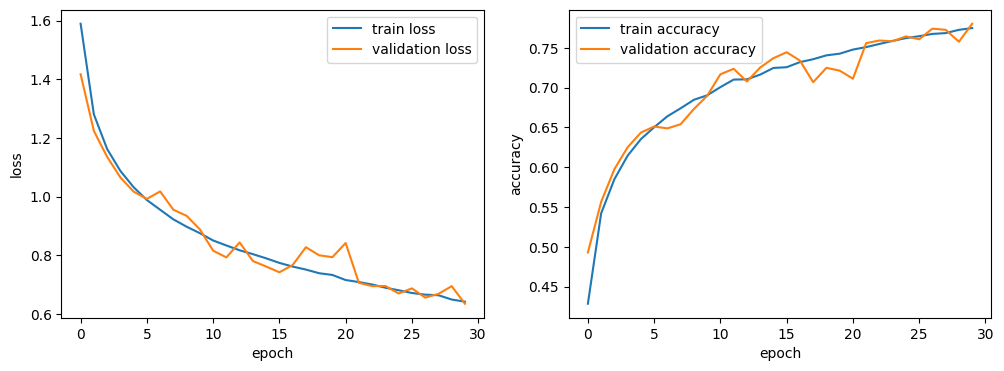

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(LOSS, label='train loss')
ax1.plot(VAL_LOSS, label='validation loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
ax2.plot(ACC, label='train accuracy')
ax2.plot(VAL_ACC, label='validation accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

### Model 평가

### model 이 어떤 image 들을 잘 맞추고 혹은 틀렸는지 시각화

In [18]:
predictions = []
labels = []

model.eval()

for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    z = model(x)
    _, y_pred = torch.max(z, 1)
    predictions.extend(y_pred.cpu().numpy())
    labels.extend(y.cpu().numpy())
    
correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]
    
print("accuracy = {:.2f}%".format(len(correct_indices) / len(predictions) * 100))

accuracy = 78.10%


Text(70.72222222222221, 0.5, 'Predicted Value')

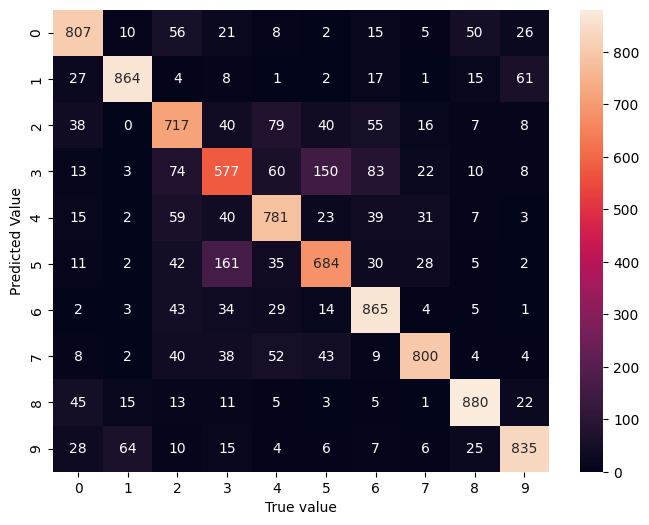

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set_xlabel('True value')
ax.set_ylabel('Predicted Value')

### 훈련된 모델을 이용한 예측 결과 시각화

`np.transpose(test_data[idx][0], (1, 2, 0))` $→$  test_data[idx][0]의 축의 순서를 바꾸는 작업.  (channel, height, width) 순서를 (height, width, channel) 순서로 변경.  

`/ 2 + 0.5` $→$ 배열의 모든 요소를 2로 나눈 후 0.5를 더하는 역정규화. 정규화는 모델 학습을 돕기 위해 데이터의 범위를 조정하는 과정. 만약 이미지 데이터가 [-1, 1] 범위로 정규화되었다면, 이 연산을 통해 원래의 [0, 1] 범위로 복원.

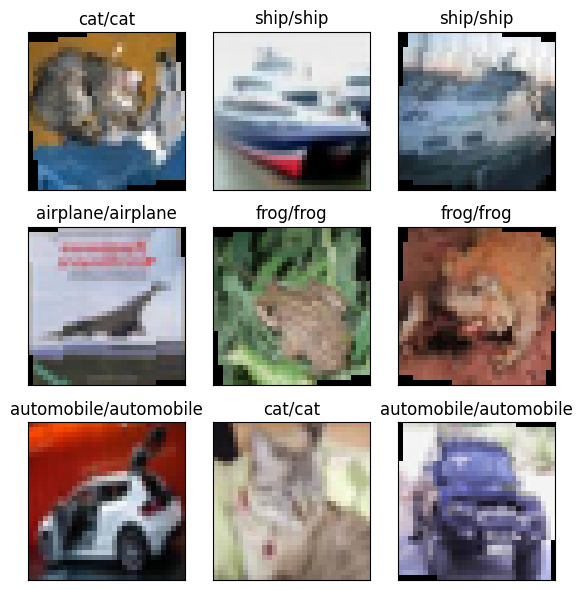

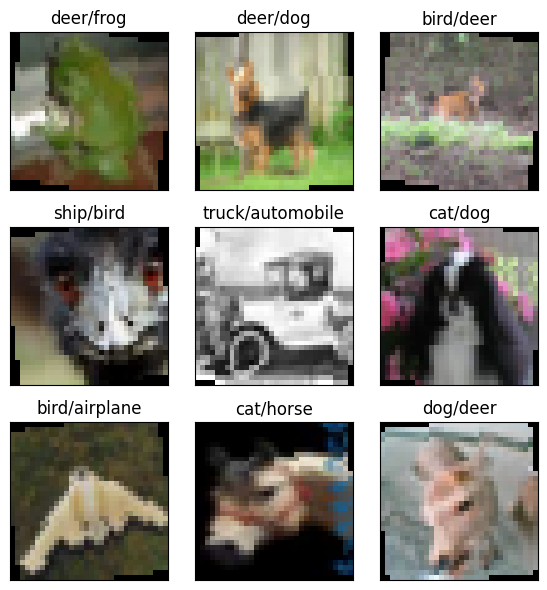

In [27]:
plt.figure(figsize=(6, 6))
for i, idx in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i+1)
    img = np.transpose(test_data[idx][0], (1, 2, 0)) / 2 + 0.5  
    plt.imshow(img)
    plt.title("{}/{}".format(cifar10_classes[predictions[idx]], cifar10_classes[labels[idx]]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

plt.figure(figsize=(6, 6))
for i, idx in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i+1)
    img = np.transpose(test_data[idx][0], (1, 2, 0)) / 2 + 0.5  
    plt.imshow(img)
    plt.title("{}/{}".format(cifar10_classes[predictions[idx]], cifar10_classes[labels[idx]]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Saving and loading the model

### state_dict 를 이용하여 모델 저장 및 loading

In [21]:
PATH = 'cifar10-cnn.pth'
torch.save(model.state_dict(), PATH)

In [22]:
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (conv_relu_stack): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Dropout(p=0.25, inplace=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1024, out_features

In [28]:
z = model(next(iter(test_loader))[0])
_, y_pred = torch.max(z, 1)

print("예측 결과 :", y_pred)
print("정답 label :", next(iter(test_loader))[1])

예측 결과 : tensor([3, 8, 8, 0, 4, 6, 1, 6, 3, 1, 0, 9, 6, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        4, 3, 2, 0, 9, 6, 6, 5, 4, 5, 9, 8, 4, 1, 9, 5, 0, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 2, 3, 8, 8, 7, 3, 3, 3, 7, 5, 6, 9])
정답 label : tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3])
